<a href="https://colab.research.google.com/github/OldGoose/ORA-Project-Santa-2021---The-Merry-Movie-Montage/blob/main/Santa_2021_TSP_ACO_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data (without preprocessing) with ACO

In this notebook, we use 4920 which is not mandatory to our initial data. The flowchart as below:
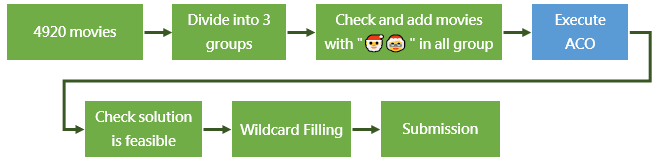
#### REFERENCES
https://www.kaggle.com/adrienbouvais/ants-for-santa-an-ant-colony-optimization  <br />
https://www.kaggle.com/yosshi999/wildcard-postprocessing-using-dynamic-programming

### Import Package

In [1]:
import itertools
import random
from random import shuffle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Santa2021') 

Mounted at /content/drive


### 1. Divide into 3 groups
From this formula $𝑝_𝑘^𝑛 = \frac{𝑛!}{(𝑛−𝑘)!}$ we can get the following seven symbols (🎅🤶🦌🧝🎄🎁🎀) with a total of 5040 permutations (ie, a total of 5040 movie)
Due to the constrain of the problem, there are a total of 120 movies starting with these 🎅🤶 two symbols, and we have to put them into each group.
After deducting those 120 films, we divide the remaining 4920 films into three equal parts.

In [2]:
LETTERS = list(map(str,range(1,8)))
permutations = [''.join(x) for x in itertools.permutations(LETTERS)]
mandatory = [x for x in permutations if x.startswith('12')]
non_mandatory = [x for x in permutations if not x.startswith('12')]
random.shuffle(non_mandatory)
print('There are',len(permutations),'movies')
print('In addition',len(mandatory),'which movie starting with 🎅🤶 must appear in each group.')

There are 5040 movies
In addition 120 which movie starting with 🎅🤶 must appear in each group.


In [3]:
#find the split point
split_id = [len(non_mandatory) // 3, len(non_mandatory)*2//3]
t1, t2 = split_id

adjust1 = 0
adjust2 = 0
group1 = non_mandatory[:t1-adjust1] + mandatory
group2 = non_mandatory[t1-adjust1:t2+adjust2] + mandatory
group3 = non_mandatory[t2+adjust2:] + mandatory

len(group1), len(group2), len(group3)

(1760, 1760, 1760)

### 3. Check and add movies with "🎅🤶" in all group.

In [4]:
all_permutations = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

for p in all_permutations:
    if p not in group1 and p not in group2 and p not in group3:
        print(p)

### 4.Execute ACO

In [5]:
# The ant class
class Ant:
    def __init__(self, map):
        self.map = map
        self.visited = np.ones((self.map.nb_city,), dtype = bool)  # Boolean of if the city has been visited
        self.position_id = self.map.city.index(random.choice(self.map.city))  # Id of current position
        self.visited[self.position_id] = 0
        self.dist_trav = 7  # Distance traveled
        self.path = self.map.city[self.position_id] # What we are looking for
        self.path_id = [0] * self.map.nb_city # History of the path for pheromones
        self.path_id[0] = self.position_id
        self.path_act_id = 1

    def update(self):
        dis, phero = self.map.dist_mat[self.position_id, :], self.map.pheros[self.position_id, :]
        dis[dis < 0] = self.map.inf_dist

        weight = (self.visited * phero) / ((dis * 2) ** self.map.coef_dist_puiss)

        next_city_id = random.choices(range(self.map.nb_city), weights=weight, k=1)[0]

        self.path += self.map.city[next_city_id][(7-int(dis[next_city_id])):]
        self.path_id[self.path_act_id] = next_city_id
        self.path_act_id += 1

        self.dist_trav += self.map.dist_mat[self.position_id, next_city_id]
        self.position_id = next_city_id
        self.visited[self.position_id] = 0

    def find_path(self):
        for i in range(self.map.nb_city-1):
            self.update()

    def update_pheros(self):
        x = 100
        coef = -50
        for i in range(x):
            if self.dist_trav <= (self.map.dist_min + self.map.dist_delta * (i / x)):
                coef += 1
        for i in range(len(self.path_id)-1):
            self.map.pheros[self.path_id[i], self.path_id[i+1]] += coef

# The map class
class Map:
    # Settings
    phero_start_fact = 1000
    inf_dist = 9999

    def __init__(self, city, dist_mat, name, coef_dist_puiss=20,
                 nb_ant=20, nb_turn=100, do_print=True):
        self.city = city # List of city to travel
        self.name = name # Name of the map
        self.nb_ant = nb_ant # Number of ants
        self.nb_turn = nb_turn # Number of turn to do
        self.dist_mat = dist_mat # Distance matrix
        
        #建立一個Array矩陣，每個欄位並乘以費洛蒙初始值 1000
        self.pheros = np.ones(self.dist_mat.shape) * self.phero_start_fact # Pheromones matrix (信息素矩陣)
        
        self.shortest_path = "" #設定初始最短路徑為空值
        self.shortest_dist = 9999999999999  #設定初始最短距離為極大值
        self.dist_min = 0
        self.dist_max = 0
        self.dist_delta = 0 #設定距離delta為0
        self.nb_city = len(city) #定義一個程式數目的變數

        self.coef_dist_puiss = coef_dist_puiss # Coef to use in ant.update, 5-10 is good
        self.ants = [] # List of ant
        for i in range(self.nb_ant):
            self.ants.append(Ant(self))

        self.pbar = None # The progress bar

    def update(self):
        ants_dist = [0] * len(self.ants)
        i = 0
        
        for ant in self.ants:
            ant.find_path()
            dis = ant.dist_trav
            ants_dist[i] = dis
            if dis < self.shortest_dist:
                self.shortest_dist = dis
                self.shortest_path = ant.path
            i+=1
            self.pbar.update(1)
        self.dist_min = min(ants_dist)
        self.dist_max = max(ants_dist)
        self.dist_delta = self.dist_max - self.dist_min
        for ant in self.ants:
            ant.update_pheros()
            ant.__init__(self)

    def start(self):
        # Start the simulation
        with tqdm(total=self.nb_turn*self.nb_ant, desc=self.name,unit="ant") as pbar:
            self.pbar = pbar
            for i in range(self.nb_turn):
                self.update()

In [6]:
dist_mat = pd.read_csv("distance_matrix.csv")
dist_mat.set_index('Permutation', inplace=True)

# 將圖案轉換為數字符號
def change(a):
    a = a.replace("🎅", "1")
    a = a.replace('🤶', "2")
    a = a.replace('🦌', "3")
    a = a.replace('🧝', "4")
    a = a.replace('🎄', "5")
    a = a.replace('🎁', "6")
    a = a.replace('🎀', "7")
    return a

def rechange(a):
    a = a.replace("1", "🎅")
    a = a.replace("2", '🤶')
    a = a.replace("3", '🦌')
    a = a.replace("4", '🧝')
    a = a.replace("5", '🎄')
    a = a.replace("6", '🎁')
    a = a.replace("7", '🎀')
    return a

def get_dist_mat(dist_mat, city):
    to_export = pd.DataFrame(columns=city, index=city) #生成一個n x n的dataframe矩陣
  
    for c in city:
        to_export.loc[c] = dist_mat.loc[c] #找出dist_mat之中，相同的city對應的欄位值，將距離填入to_export對應的欄位中(https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/462517/)

    to_export = to_export.to_numpy() #將to_export型態由dataframe轉為array型態
    to_export[to_export==0] = 99999 #將to_export裡面為0的值改為99999

    return to_export

# 建立字典，將dist_mat裡面的欄跟列的名稱改換為數字字符
dic = {}
for c in dist_mat.columns:
    dic[c] = change(c)
dist_mat.rename(dic, axis=1, inplace=True)
dist_mat.rename(dic, axis=0, inplace=True)

#### Set papameter

In [7]:
starttime = datetime.datetime.now()

nb_ant = 5 #number of ants
nb_turn = 30 # Number of turn to do
coef_dist_puiss = 50

print("The calculation will take approximately " + str(datetime.timedelta(seconds=(1.2 * 3 * nb_ant * nb_turn))))
print('Start for nb_ant:', nb_ant, ', nb_turn', nb_turn, )

dist_mat_map_1 = get_dist_mat(dist_mat, group1)
map_1 = Map(group1, dist_mat_map_1, "map_1", nb_ant=nb_ant, nb_turn=nb_turn,
            coef_dist_puiss=coef_dist_puiss, do_print=False)

map_1.start()
print("map_1 Done, score:", map_1.shortest_dist, 'Nb_city:', len(group1))

dist_mat_map_2 = get_dist_mat(dist_mat, group2)
map_2 = Map(group2, dist_mat_map_2, "map_2", nb_ant=nb_ant, nb_turn=nb_turn,
            coef_dist_puiss=coef_dist_puiss, do_print=False)
map_2.start()
print("map_2 Done, score:", map_2.shortest_dist, 'Nb_city:', len(group2))

dist_mat_map_3 = get_dist_mat(dist_mat, group3)
map_3 = Map(group3, dist_mat_map_3, "map_3", nb_ant=nb_ant, nb_turn=nb_turn,
            coef_dist_puiss=coef_dist_puiss, do_print=False)
map_3.start()
print("map_3 Done, score:", map_3.shortest_dist, 'Nb_city:', len(group3))


The calculation will take approximately 0:09:00
Start for nb_ant: 5 , nb_turn 30


map_1:   0%|          | 0/150 [00:00<?, ?ant/s]

map_1 Done, score: 4641 Nb_city: 1760


map_2:   0%|          | 0/150 [00:00<?, ?ant/s]

map_2 Done, score: 4761 Nb_city: 1760


map_3:   0%|          | 0/150 [00:00<?, ?ant/s]

map_3 Done, score: 4714 Nb_city: 1760


### 5. Check solution is feasible

In [8]:
string1 = (map_1.shortest_path)
string2 = (map_2.shortest_path)
string3 = (map_3.shortest_path)

In [9]:
all_permutations = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

for p in all_permutations:
    if p not in string1 and p not in string2 and p not in string3:
        print(p)
              
for p in mandatory:
    if p not in string1 and p not in string2 and p not in string3:
        print(p)
#No News is good news.

In [10]:
result_list = [string1, string2, string3]
for i in range(3):
  print('The length for group' + str(i+1) + ' without wildcards ' +  str(len(result_list[i])))

The length for group1 without wildcards 4641
The length for group2 without wildcards 4761
The length for group3 without wildcards 4714


In [11]:
sub = pd.DataFrame()
sub['schedule'] = [string1, string2, string3]
schedule = sub.schedule.tolist()

### 6. Using Dynamic Programming to filling the 🌟

#### Create Cost martix

In [12]:
perms = list(map(lambda p: "".join(p), itertools.permutations("1234567")))
perm2id = {p: i for i, p in enumerate(perms)}

perms_arr = np.array([list(map(int, p)) for p in perms])
perms_arr.shape

perms_onehot = np.eye(7)[perms_arr-1, :].transpose(0, 2, 1)
assert np.allclose(perms_onehot[:,0,:].astype(np.int64), (perms_arr == 1).astype(np.int64))

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_right2left = np.array([0, 1, 2, 3, 4, 5, 6, 7, -1, -1, -1, -1, -1, -1, -1])
cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

M = F.conv2d(
    F.pad(torch.Tensor(perms_onehot[:, None, :, :]), (7, 7)),
    torch.Tensor(perms_onehot[:, None, :, :]),
    padding="valid"
).squeeze().numpy()

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_left2right_wild = np.array([-1, -1, -1, -1, -1, -1, -1, 6, 5, 4, 3, 2, 1, 0, 0])

cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

costMat = np.where(M == must_match_left2right, cost_ifmatch, np.inf).min(axis=-1).astype(np.int8)
costMatWild = np.minimum(costMat, np.where(M == must_match_left2right_wild, cost_ifmatch, np.inf).min(axis=-1)).astype(np.int8)

#### String decomposition

In [13]:
perms = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

def find_strings_perms(strings, verbose=False):
    global perms
    found_perms = []
    for s in strings:
        found_perms.append([])
        for i in range(len(s)-6):
            p = s[i:i+7]
            if p in perms:
                found_perms[-1].append(p)
    if verbose:
        lens = [len(_) for _ in  found_perms]
        print(f'There are {lens} permutations in strings, {sum(lens)} in total.')
        lens = [len(set(_)) for _ in  found_perms]
        print(f'There are {lens} unique permutations in strings, {sum(lens)} in total.')
    return found_perms

def rebalance_perms(strings_perms, verbose=False):
    # convert to dicts for fast lookup and to keep permutations order
    strings_perms = [dict.fromkeys(_) for _ in strings_perms] 
    for p in strings_perms[0].copy():  # iterate over the copy to allow modification during iteration
        if p[:2] != "12" and (p in strings_perms[1] or p in strings_perms[2]):
            strings_perms[0].pop(p)
    for p in strings_perms[1].copy():
        if p[:2] != "12" and p in strings_perms[2]:
            strings_perms[1].pop(p)
    if verbose:
        lens = [len(_) for _ in  strings_perms]
        print(f'There are {lens} permutations left in strings after rebalancing, {sum(lens)} in total.')
    return [list(_) for _ in strings_perms] 

In [14]:
found_perms = find_strings_perms(schedule, verbose=True)
balanced_perms = rebalance_perms(found_perms, verbose=True)

There are [2545, 2615, 2624] permutations in strings, 7784 in total.
There are [2491, 2560, 2553] unique permutations in strings, 7604 in total.
There are [1052, 1675, 2553] permutations left in strings after rebalancing, 5280 in total.


#### Run

In [15]:
nodes_list = []
table_list = []
for i in range(3):
    word = balanced_perms[i]
    nodes = [perm2id[p] for p in balanced_perms[i]]

    table = np.zeros((len(nodes), 10), np.int64)
    table[0, :] = 7
    for i in range(1, len(nodes)):
        e = costMat[nodes[i-1], nodes[i]]
        ew = costMatWild[nodes[i-1], nodes[i]]
        table[i,0] = table[i-1,0] + e
        table[i,1] = min(table[i-1,1] + e, table[i-1,0] + ew)
        table[i,2] = min(table[i-1,2], table[i-1,1]) + e # TODO: better transition
        table[i,3] = min(table[i-1,3], table[i-1,2]) + e
        table[i,4] = min(table[i-1,4], table[i-1,3]) + e
        table[i,5] = min(table[i-1,5], table[i-1,4]) + e
        table[i,6] = min(table[i-1,6], table[i-1,5]) + e
        table[i,7] = min(table[i-1,7], table[i-1,6]) + e
        table[i,8] = min(table[i-1,8], table[i-1,7]) + e
        table[i,9] = min(table[i-1,9] + e, table[i-1,8] + ew)
    print(table[-1].min(), table[-1])
    nodes_list.append(nodes)
    table_list.append(table)
    
# backtrack
new_words = []
wilds = []
for nodes, table in zip(nodes_list, table_list):
    ns = [perms[nodes[-1]]]
    track = np.argmin(table[-1])
    wild = []
    for i in range(len(nodes)-2, -1, -1):
        e = costMat[nodes[i], nodes[i+1]]
        ew = costMatWild[nodes[i], nodes[i+1]]
        if track == 0:
            ns.append(perms[nodes[i]][:e])
        elif track == 1:
            if table[i, 1] + e < table[i, 0] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                ns.append(perms[nodes[i]][:ew])
                track = track - 1
        elif 2 <= track <= 8:
            if table[i, track] >= table[i, track-1]:
                track = track - 1
            ns.append(perms[nodes[i]][:e])
        elif track == 9:
            if table[i, 9] + e < table[i, 8] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                ns.append(perms[nodes[i]][:ew])
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                track = track - 1
        else:
            assert False
    assert track == 0
    wilds.append(wild)
    nsw = list("".join(ns[::-1]))
    for w in wild:
        nsw[w] = "*"
    new_words.append("".join(nsw))

3814 [3825 3819 3819 3819 3819 3819 3819 3819 3819 3814]
4427 [4439 4433 4433 4433 4433 4433 4433 4433 4433 4427]
4709 [4714 4710 4710 4710 4710 4710 4710 4710 4710 4709]


In [16]:
endtime = datetime.datetime.now()
print("score: ", max(map(len, schedule)), "->", max(map(len, new_words)))
print("execution time : ", endtime - starttime)

score:  4761 -> 4709
execution time :  0:15:22.160682


### 7. Submission

In [17]:
symbols = "🎅🤶🦌🧝🎄🎁🎀🌟"
submission = pd.Series([a.translate(str.maketrans("1234567*", symbols)) for a in new_words], name='schedule')
submission.to_csv('submission.csv', index=False)